# Gaussian Mixture Models and Maximum Likelihood Estimation

In the previous lab session, we used distance metrics in a $d$-dimensional feature space to find the best clustering. While k-means is very useful in many situations, in some cases it will still fail. In such case, it can help to take a probabilistic approach and view the items in your dataset as samples from an unknown probabilistic distribution.  Specifically, we will assume that all samples belonging to one cluster are statistically distributed according to a Gaussian (=normal) distribution. Since we have multiple clusters, we need a *mixture* of Gaussians to accurately model the sample distribution.

The ML problem is then to learn the parameters of this distribution, e.g. the mean and variance of the Gaussian. The result is a **generative** model that can also be used for anomaly detection, or to generate new data. We will also explore these applications of generative modelling. 

## When k-means clustering fails

Since k-means uses Euclidean distance between features, it was important to apply feature scaling to ensure that your data has the same variance along each dimension. But there are many realistic situations where k-means will fail, despite this normalization. This is the case when your clusters have an ellipsoidal shape.

<font color='red'>Task: run the code below to load the data and to plot the distribution.</font>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('Clustering_gmm.csv')

plt.figure(figsize=(7,7))
plt.scatter(data["Weight"],data["Height"])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Data Distribution')
plt.show()

<Figure size 700x700 with 1 Axes>

<font color='red'>Task: 
* normalize your features with a <tt>StandardScaler</tt> and apply k-means with 4 clusters. 
* Visualize the clustering with the method provided below. Make separate plots for the scaled and for the unscaled data.</font>

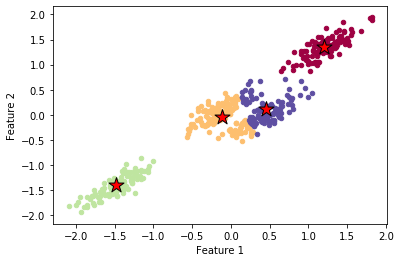

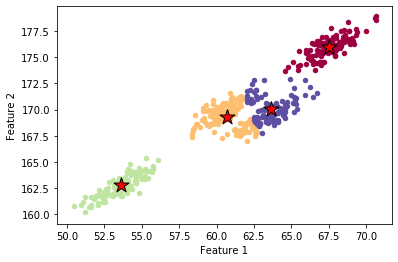

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

#use this function to visualize the clustering
def plotClusters2D(data, cluster_labels, cluster_centers = None):  
    '''
    This function plots the data items, using a different color per cluster. If cluster_centers are provided, these are also plotted.
    
    Args:
    * data: Numpy array of tuples: [[item1_x, item1_y], [item2_x, item2_y] ,... ]
    * cluster_labels: an array of integers containing the cluster number for each data item: 
    * cluster_centers: optional, an array of tuples containing the feature values of the cluster centers [[center1_x, center1_y], [center2_x,center 2_y]...]
    
    '''
    
    plt.figure() 
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
          # Black used for points not assigned to a cluster (will be useful for other algorithms, k-means assigns each element to a cluster)
          col = [0, 0, 0, 1]        
        
        plt.scatter(data[cluster_labels == k,0],data[cluster_labels == k,1],s=20,c=[col])

    if cluster_centers is not None:        
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=250, marker='*', c='red', edgecolor='black')
  
    plt.xlabel('Feature 1') ;   
    plt.ylabel('Feature 2');
    
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
#training k-means model

kmeans = KMeans(n_clusters=4)
kmeans.fit(scaled_data)

#predictions from kmeans
pred = kmeans.predict(scaled_data)

plotClusters2D(scaled_data, pred, kmeans.cluster_centers_)
plotClusters2D(data.to_numpy(), pred, scaler.inverse_transform(kmeans.cluster_centers_))

Even after normalization, the result of k-means is clearly unsatisfactory. K-means faces three problems:
* data points are assigned to the closest cluster center. This means that **k-means cannot produce ellipsoidal cluster shapes**. You observe this effect in the two clusters in the middle. The separation line indicates the points at equal distance from both centroids.
* visually, we cluster based on the density of the data points. White areas in feature space, where there are no data points, are an indication of cluster boundaries. But **k-means does not account for differences in density**.
* k-means provides hard clustering: each data point is assigned to precisely one cluster. But imagine you have a person that weighs 63kg and is 171 cm tall. This person could belong to any of the two groups, so your clustering is quite uncertain. **k-means does not give an indication of uncertainty**.

## Viewing your data through a probabilistic lens

If all features in your dataset are continuous, you can think of each sample as a point in an $n$-dimensional space. In most realistic datasets, these points will not be uniformly spread over the feature space: some regions will contain more points than others. 

When clustering, we will make the assumption that the samples of each cluster are Gaussian distributed. The underlying idea is that there is always some variation between all individuals of the same group. Our goal will then be to identify the **number** of Gaussians (groups) in the dataset, and to estimate the mean and variance of the Gaussian distribution of each group.

Let us start by visualizing the idea that features of members of an individual group are Gaussian distributed. We will use the Iris dataset containing 150 feature vectors of iris flowers. There are 50 samples for each of three types of iris flowers: *setosa*, *versicolor* and *virginica*. We will use these labels to validate the result of the clustering.

The features relate to the width and length of the two leaf types of an iris, as shown below.

![petal](./images/petal_sepal.jpg)

<font color='red'>Task: load the data set with the code below</font>

In [7]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
iris = load_iris()
iris_data = pd.DataFrame(np.concatenate((iris.data, np.array([iris.target]).T), axis=1), columns=iris.feature_names + ['target'])
print("Types of iris flowers: ",iris.target_names)
iris_data.sample(n=5)

Types of iris flowers:  ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
46,5.1,3.8,1.6,0.2,0.0
129,7.2,3.0,5.8,1.6,2.0
0,5.1,3.5,1.4,0.2,0.0
90,5.5,2.6,4.4,1.2,1.0
132,6.4,2.8,5.6,2.2,2.0


<font color='red'>
Task: Inspect the feature distribution of each flower type separately by making *separate* pairplots per type. Put the feature histogram on the diagonal of each pairplot. Pairplot is in the <tt>Seaborn</tt> module. If needed, set the scale of the Y-axis to the interval [0,6].

* Can you discern (approximately) a normal distribution in the histogram of most features?
* Can you observe ellipsoidal regions in the scatterplots with high density of data points? Since all features are in cm, the notion of distance is the same along all axes and the ellipses will not disappear by rescaling.
</font>

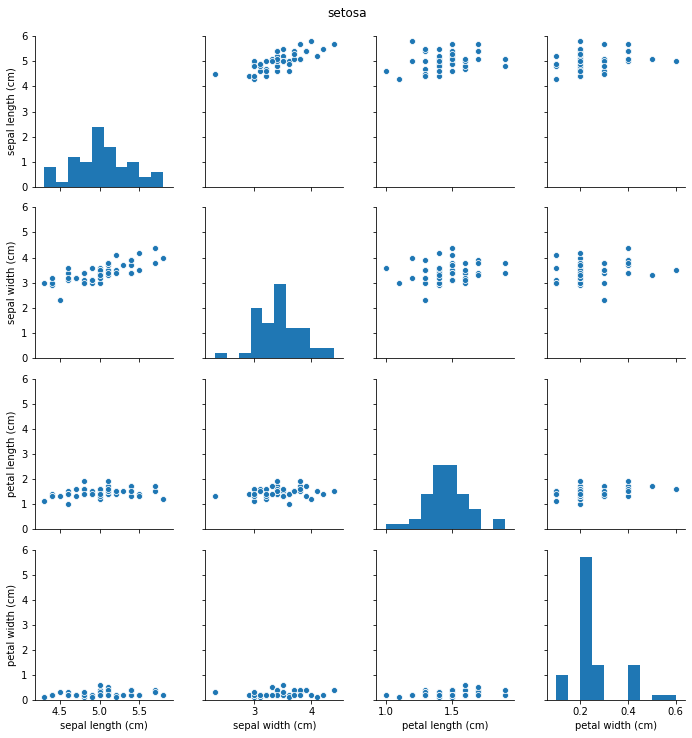

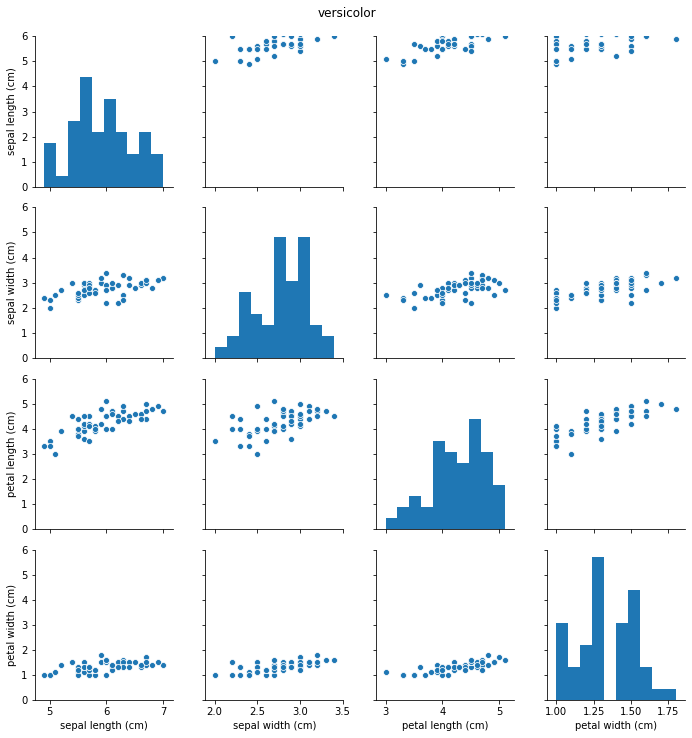

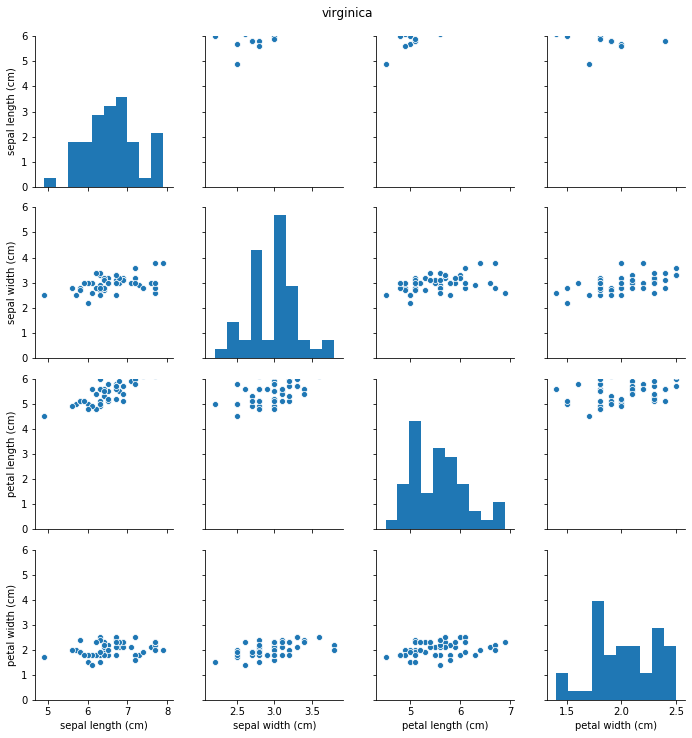

In [8]:
import seaborn as sns

for t, name in enumerate(iris.target_names):           
    g=sns.pairplot(iris_data[iris.target==t].iloc[:,0:4],diag_kind="hist");
    g.fig.suptitle(name,y=1.02);
    #g.set(xlim=(0,6))
    g.set(ylim=(0,6))
    plt.show();  


For now, let's continue working on only the data of the "setosa" type (target==0). Imagine to divide each axis in the 4-D feature space in equal intervals. This creates an imaginary grid of 4-D cubes. You can now count the number of samples in your dataset that fall in each bin. If your dataset is sufficiently large, the fraction of samples in each bin becomes an indication of the probability that an unseen iris flower will have a combination of feature values that falls in this bin.

Visualization is only possible in 2D. Let's create an imaginary grid over the 2-dimensional space spanned by the features of sepal length and width, and count the number of samples in each (square) bin. You can then create a 3D bar plot that shows what fraction of the samples in the dataset falls in each bin.

<font color='red'>Task: run the code below to visualize the result of the binning.</font>

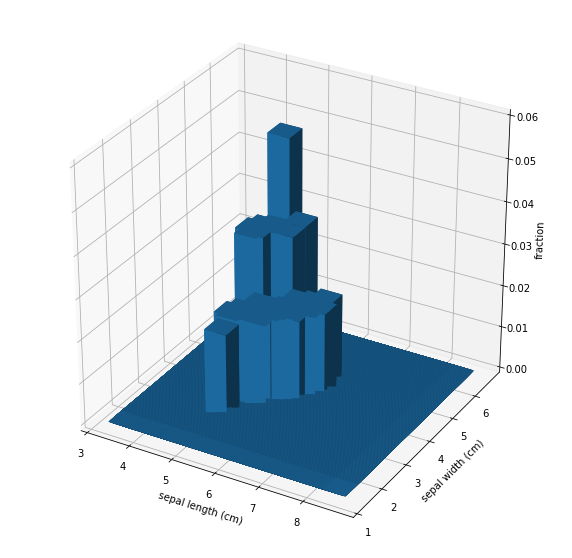

In [9]:
from mpl_toolkits.mplot3d import Axes3D

iris_data.loc[iris_data['target']==0.0,'sepal length (cm)']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(iris_data.loc[iris_data['target']==0.0,'sepal length (cm)'].to_numpy(), iris_data.loc[iris_data['target']==0.0,'sepal width (cm)'].to_numpy(), bins=150, range=[[3, 8], [1, 6]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
N=iris_data[iris_data['target']==0.0].shape[0]
dz = 1/N*hist.ravel() #normalize

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='max')
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')
ax.set_zlabel('fraction')
plt.show()

By dividing the counts of each bin with the total number of elements in the dataset, you get an estimate of the probability that a random sample in your dataset falls into a particular bin. This is obviously only an approximation of the true probability, but the more data we have, the better these estimates will be.

Our current bins are discrete. But if we would have more data, we could reduce the bin size. If we would have a very large dataset, we could make the bin size very small. The tops of all bars would then form a surface. In the limit, we would get a continuous function, the **probability density function** $p_{data}(x_1,x_2,x_3,x_4)$, with $x_i$ continuous variables referring to the sepal length, width, petal length and petal width respectively. Usually our data is of much higher dimension $d$, and we use a shorthand notation:
$$
p_{data}(\textbf{x}) \textrm{ with } \textbf{x} = [x_1,x_2,...,x_d]
$$

We again remind you that the **probability density function** can take values larger than 1. The only requirement is that its integral over all possible feature values sums to 1. 

Our goal will be to fit from our dataset a continuous function $p_{model}$ that is a good approximation of the unknown density distribution $p_{data}$. In our example, we will seek for a probability density distribution $p_{model}(\textrm{sepal length},  \textrm{ sepal width},  \textrm{ petal length},  \textrm{ petal width})$.

## Parametric families of probability distributions

In principle, there are an infinite number of possible probability density functions $p_{model}$. Any continuous function is a valid candidate, on condition that the integral of this function over all possible values of $x$ equals to 1. This leaves us with a lot of candidates.

To help our Machine Learning algorithm, we need to reduce the set of candidate functions. We do this by selecting a **family of probability distributions**. Each member of this family is a function with the same mathematical function, but a different value for its parameter set. This parameter set is denoted by $\mathbf{\theta} = [\theta_1, \theta_2, ... \theta_p]$.
The ML algorithm then only needs to estimate the correct value of the vector $\mathbf{\theta}$. To explicitly indicate that the algorithm is trying to find a function within a family of functions, the following notation is used:

$$
\begin{align}
p_{model}(\mathbf{x};\mathbf{\theta}) &= p_{model}(x_1, x_2, ..., x_d;\mathbf{\theta}) \\
&= p_{model}(x_1, x_2, ..., x_d;\theta_1,\theta_2,...,\theta_p) 
\end{align}
$$

Mind the semicolon. All letters before the semicolon refer to the features in our dataset. All letters after the semicolon refer to parameters of the chosen family. 

For instance, if we have onedimensional data, we could choose for the family of exponential distributions, with $\mathbf{\theta} = [\lambda]$. All negative values of $x$ have a probability of zero. For positive values of $x$, the following function is used:
<br/><br/>

$$
p_{model}(x;\lambda) = \lambda {\rm e}^{-\lambda x}
$$
    
Another (very common) choice would be the family of Gaussian (or normal) distributions, with $\mathbf{\theta} = [\mu, \sigma]$.

$$
p_{model}(x;\mu,\sigma) = \mathcal{N}(\mathbf{x};\mu,\sigma) = \frac{1}{\sqrt{2 \pi} \sigma}{\rm e}^{-\frac{(x-\mu)^2}{2 \sigma^2}}
$$

<font color='red'>Task: plot a few members of each family. Experiment with different values for the parameter to understand their effect on the shape of the distribution.</code>

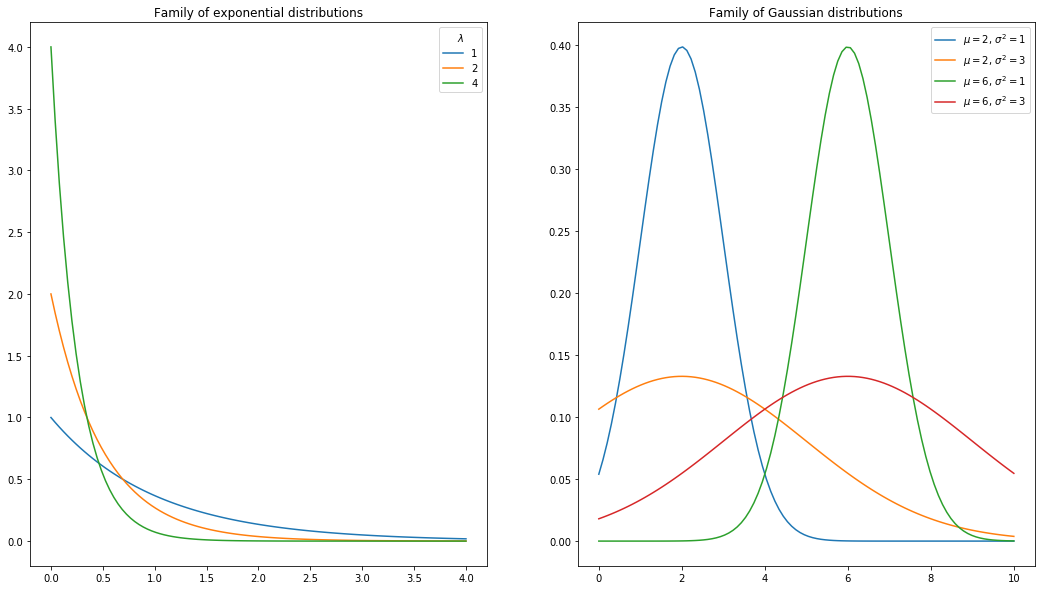

In [10]:
from scipy.stats import expon,norm

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].set_title("Family of exponential distributions")
axes[1].set_title("Family of Gaussian distributions")

values=[1,2,4]
for par_lambda in values:        
    xv = np.linspace(0.0001,4, 100);
    sns.lineplot(x=xv,y=expon.pdf(xv,scale=1/par_lambda),ax=axes[0]);    
axes[0].legend(values,title='$\lambda$');
    
mu=[2, 6]
sigma=[1, 3]
legend_titles = []
for par_mu in mu:
    for par_sigma in sigma:
        xv=np.linspace(0,10,100);
        sns.lineplot(x=xv, y=norm.pdf(xv,loc=par_mu,scale=par_sigma),ax=axes[1])
        legend_titles.append(f"$\mu = {par_mu}$, $\sigma^2 = {par_sigma}$")

axes[1].legend(legend_titles)

## Parameters of the multivariate Gaussian distribution

The presented examples were all families of univariate distributions: they only model the statistical distribution of a single feature. In ML, we work with feature vectors of higher dimensionality. In $d$-dimensions, the probability density function of the multivariate Gaussian is given by:

$$
p_{model}(\mathbf{x};\mathbf{\mu},\mathbf{\Sigma}) = \frac{1}{\sqrt{\left(2 \pi \right)^{d} |\Sigma|}}\rm{exp}\left(-\frac{1}{2}\left(\mathbf{x} - \mathbf{\mu}\right)^T \mathbf{\Sigma^{-1}}\left(\mathbf{x}-\mathbf{\mu}\right)\right)
$$

This is a probability **density** function, which means it can take values larger than 1 for some values. This also means that you cannot interpret the value at a particular point to be the probability of that point.

In this notation, $\mathbf{x}$ represent a column vector of dimension $d$ (usually, we work with row vectors!)
$\mathbf{x} = \begin{bmatrix} 
x_1 \\ 
x_2 \\ 
... \\
x_d
\end{bmatrix}
$

The parameters of this distribution are the column vector of dimension $d$ with averages along each axis: $\mathbf{\mu} = \begin{bmatrix} 
\mu_1 \\ 
\mu_2 \\ 
... \\
\mu_d \\
\end{bmatrix}$

and a $d \times d$ **covariance matrix** containing the covariance between each pair of dimensions:
$
\mathbf{\Sigma} = \begin{bmatrix} 
\sigma_{x_1}^2 & K_{12} & ... K_{1d} \\ 
K_{12} & \sigma_{x_2}^2 & ... K_{2d} \\ 
... \\
K_{1d} & K_{2d} & ... \sigma_{x_d}^2 \\ 
\end{bmatrix}$ 

with determinant det($\Sigma$)=|$\Sigma$| and $K_{ij}$ the covariance between dimensions $i$ and $j$:

$$K_{ij} = K_{ji} = \mathbb{E}\left[(x_i - \mu_i)(x_j - \mu_j)\right]$$
            
The covariance matrix is always symmetric and must be invertible, which means its determinant is non-zero.
In 2D, the covariance matrix can be written in terms of the variance $\sigma_x$, $\sigma_y$ and the **correlation** $\rho$:

$
\mathbf{\Sigma} = \begin{bmatrix} 
\sigma_{x_1}^2 & \rho\sigma_{x_1}\sigma_{x_2} \\ 
\rho\sigma_{x_1}\sigma_{x_2} & \sigma_{x_2}^2\\ 
\end{bmatrix}$ 


<font color='red'>Task: 
* use the plot code below to better understand the effect of the parameter values for the mean and covariance of a 2-D Gaussian. The plot shows in 3D the value of the density function. This is also projected on the 2D surface in a so called **density plot**.
* The mean vector determines the center of the distribution, whereas the covariance matrix determines the shape of the ellipse. Adjust the parameters of the covariance matrix to find a density function with
  * circular shape
  * ellipsoidal shape, with the longest axis aligned with the X-axis
  * ellipsoidal shape with the axes not aligned with the coordinate system
</font>

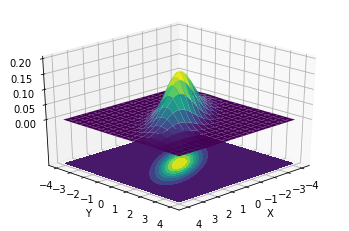

In [22]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-4, 4, N)
Y = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
#Circular shape: diagonal matrix with equal elements 
Sigma = np.array([[ 1. , 0], [0,  1]])
#Ellipsoid, aligned with X-axis: diagonal matrix with different values, largest value along X
Sigma = np.array([[ 2. , 0], [0,  1]])
#Ellipsoid, not-aligned with coordinate system
Sigma = np.array([[ 2. , 1], [1,  1]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax.set_xlabel("X")
ax.set_ylabel("Y")
cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, +45)

plt.show()

## Our roadmap 

Remember that our assumption is that our data contains several clusters, and that the samples of each cluster are distributed with a member of the Gaussian family. We thus need to find both the number of clusters, as well as the parameter $\mathbf{\mu}$ and $\mathbf{\Sigma}$ for each of the cluster distributions.

We will tackle the problem in steps of increasing complexity:
* one-dimensional data, one cluster: First, we will assume that our samples have only a single feature, and that all samples in our dataset belong to the same cluster. You will learn how to use Maximum Likelihood Estimation to find the parameters of this distribution.
* one-dimensional data, multiple cluster: Then, we will learn how to estimate both the number of clusters as the parameters of each cluster distribution
* multi-dimensional data, multiple clusters: this is the most generic setting.

For the first two steps, we will look into a realistic application: Non-Intrusive Load Monitoring. In the last step, we will come back to our Iris flower dataset.

# One dimension, one Gaussian

## Application: Non-Intrusive Load Monitoring (NILM)

NILM aims to break down the overall power consumption of a household into power profiles of individual appliances. The technique is called non-intrusive since it does not require to install sensors on each device. The principle is illustrated in the figure below. Identifying individual appliances has applications in e.g. electrical grid balancing where one can activate additional appliances if the power consumption of solar panels is high. 

<figure>
<img src="./images/nilm_principle.png" alt="drawing" width="500"/>
<figcaption> Image taken from Aladesanmi and Folly, Overview of non-intrusive load monitoring and identification techniques. </figcaption>
</figure>

Switching a device on or off will result in a jump or drop of the total power consumption. The height of this difference is specific to each device. Therefore, we will first model the distribution of these differences for individual appliances with a Gaussian distribution. One has collected training data by sensors mounted on individual appliances.

Once this distribution is learned for each applicance, we could limit ourselves to monitoring the overall power switch (hoofdschakelaar). Each time a jump or drop in the power consumption is observed, we could then use these distributions to calculate the probability that this new event is due to a particular device. The switching event could then e.g. be classified as belong to the class for which the highest probability density was found. 

We will make use of the REDD dataset, which contains the overall power consumption of several households, as well as individual profiles for several appliance types. This dataset can be easily explored and manipulated with the convenient nilmtk package.
Let's explore the dataset first. 

<font color='red'>Try to answer the following questions from the metadata. 
* In how many households was data collected? 
* How was the aggregate (total) load measured? 
* How was the individual load measured?
</font>

In [8]:
#one time conversion of raw data to h5 format
#from nilmtk.dataset_converters import convert_redd
#convert_redd('./low_freq', './redd.h5')

In [9]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

redd=DataSet('./redd.h5')
print_dict(redd.metadata)

We will work on the data of a single household (instance 1). 

<font color='red'>Try to answer the following questions:
* How many devices were used to measure the site energy consumption?
* What appliances were in the house?
* Which appliances were measured with multiple meters?
</font>

In [10]:
print_dict(redd.buildings)
elec=redd.buildings[1].elec
print(elec)

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

### Distribution of power differences due to oven switch events

<font color='red'>Plot the power consumption of the electric oven. </font>

Hint: you can select an appliance easily by indexing in the <tt>MeterGroup</tt> object based on instance number. This will select an <tt>ElecMeter</tt> object, which has a <tt>plot</tt> method. See the plot method of the <tt>Electric</tt> class, which is the base class of <tt>ElecMeter</tt>: [documentation](http://nilmtk.github.io/nilmtk/master/nilmtk.html?#nilmtk.electric.Electric)

Meter 3 is in a nested meter group. Retrieving just the ElecMeter.


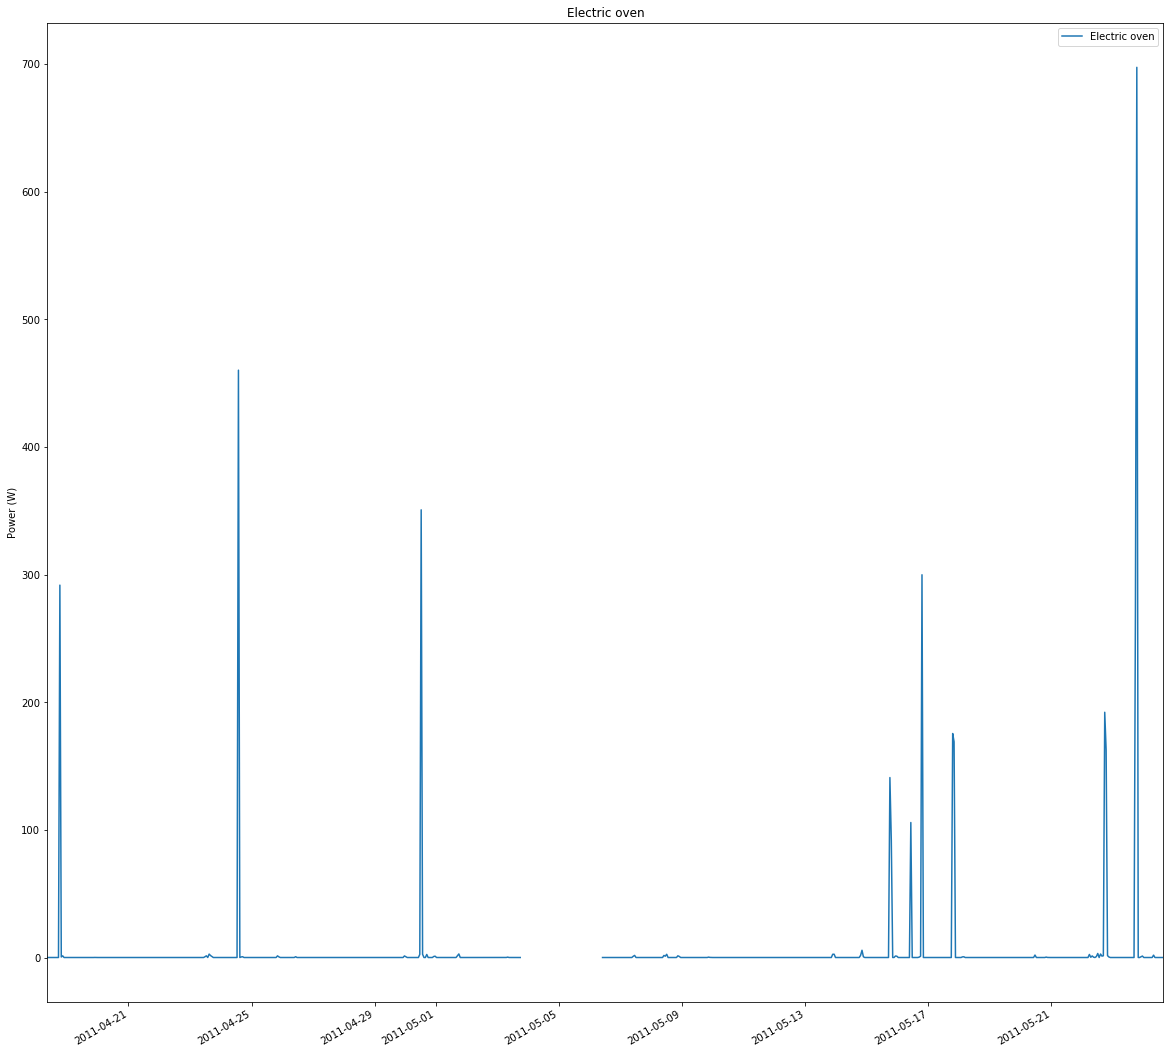

In [11]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
from nilmtk import MeterGroup

#instances to plot
plt.figure(figsize=(20,20));
plt.title('Electric oven');
elec[3].plot();  
  

<font color='red'>Task:
* Load the raw data of the oven and inspect this data. 
* Create a dataframe containing the **absolute value** of the difference in active power between subsequent rows. 
* Plot a histogram of these differences, using 100 bins.
</font>

Meter 3 is in a nested meter group. Retrieving just the ElecMeter.


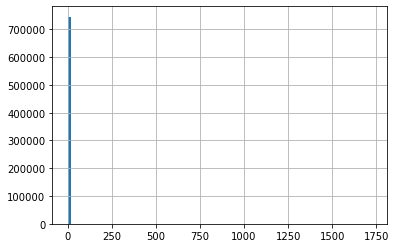

In [12]:
oven_data=next(elec[3].load());
diff_oven=abs(oven_data.power.active.diff());
diff_oven.hist(bins=100);

The dataset is clearly dominated by a large number of very small differences. These differences are simply reflecting the noise and not indicative for switching events. Remember that we are studying the data of an oven, which typically consumes several hundreds of Watts.
We should thus discard all power differences below a particular threshold. Instead of intuitively selecting this threshold value, we will follow a more principled approach.<br><br>

<font color='red'>
Plot an empirical cumulative distribution function, which shows the number of items in your dataset that is larger than a particular value. Use the function <a href="https://seaborn.pydata.org/generated/seaborn.ecdfplot.html
"> ecdfplot</a> of the Seaborn library.

Use the count statistic and make sure to plot the complementary CDF. Determine an optimal threshold value, which is a value which excludes most of the noise. To properly inspect the graph, you have to zoom in on the lower part of the Y-axis.
</font>

(0, 200)

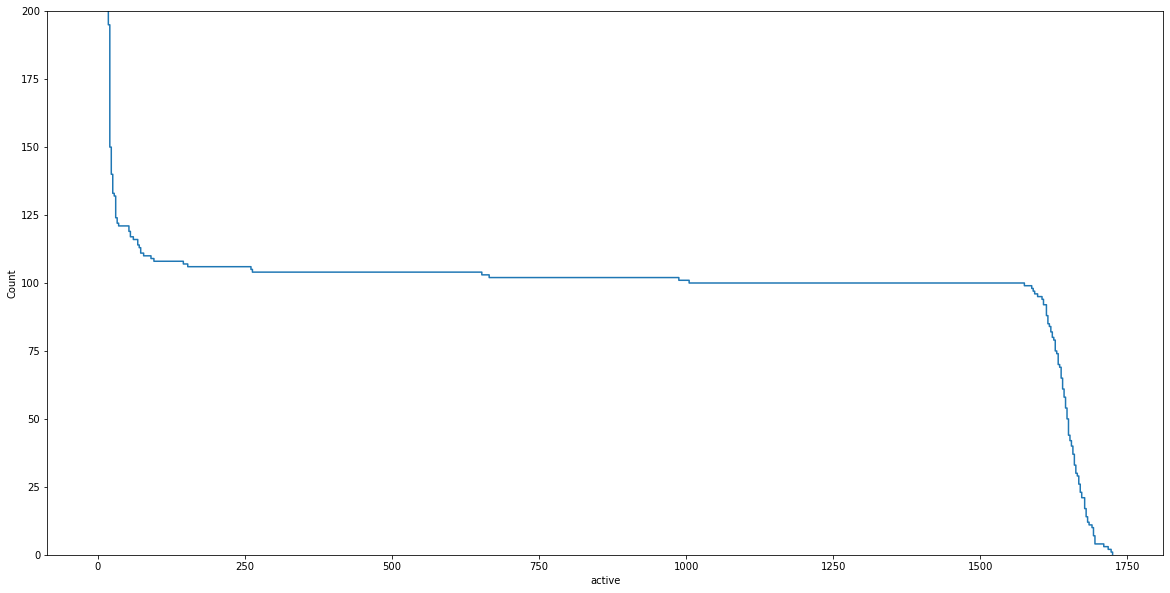

In [13]:
import seaborn as sns
plt.figure(figsize=(20,10));
sns.ecdfplot(data=diff_oven, stat="count",complementary=True)
plt.ylim(0,200)


<font color='red'>Choose a threshold, and plot a new histogram on your filtered data. Use 100 bins. Do you agree that the (univariate) Gaussian distribution seems to be a good choice?</font>

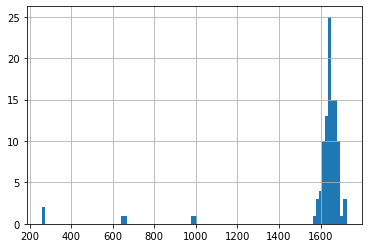

In [14]:
diff_oven[(diff_oven>200)].hist(bins=100);

## Method: Maximum Likelihood Estimation

Hopefully, you are convinced that the family of Gaussian distributions is a good choice for this problem. All that is left is to find the value for the parameters $\mathbf{\theta} = [\mu, \sigma]$ that best explains our given dataset.

The best probability function we can find is that function in our family that maximizes the **joint** probability of all items in our dataset. But usually, we assume that all our datasets are identically and independently distributed, an assumption that usually holds in practice. This means that we can describe the joint probability as the product of the individual assumptions. This product is called the **likelihood** function:

$$
\begin{align}
\mathcal{L}(\mathbf{\theta};\mathbf{x_{data}}) = \prod_{i=1}^n p_{model}(x^{(i)};\mathbf{\theta})
\end{align}
$$

In the above formula $x^{(i)}$ denotes the $i$-th sample in our dataset consisting of $n$ samples.
Observe that this likelihood is only a function of $p$ parameters $\mathbf{\theta} = [\theta_1,...,\theta_p]$.

To find the values $\hat\theta$ that maximize the likelihood, you can take the partial derivatives and solve the set of equations:
$$
\begin{align}
\frac{\partial \mathcal{L}(\mathbf{\theta};\mathbf{x_{data}})}{\partial \theta_1}  &= 0 \\
\frac{\partial \mathcal{L}(\mathbf{\theta};\mathbf{x_{data}})}{\partial \theta_2}  &= 0 \\
...\\
\frac{\partial \mathcal{L}(\mathbf{\theta};\mathbf{x_{data}})}{\partial \theta_p}  &= 0 \\
\end{align}
$$
The likelihood is a product of small numbers, which may lead to numerical instabilities. Taking a logarithm of a product is the sum of the logarithms. Because $\log(x)$ is a strictly increasing function, maximizing the logarithm of the likelihood will give the same result, but now a summation must be maximized. Another advantage of the logarithm is that it will cancel out the exponentials that are present in probability density functions like the exponential and Gaussian distribution. Numerically, minimization of a function is also more tractable than maximization of a function. For all these reasons, ML experts will therefore find the optimal parameters by minimizing the **negative loglikelihood**:

$$
\begin{align}
 \hat{\theta} &=\underset{\mathbf{\theta}}{\operatorname{argmax}} \mathcal{L}(\mathbf{\theta};\mathbf{x_{data}}) \\
              &=\underset{\mathbf{\theta}}{\operatorname{argmin}} -\mathcal{L}(\mathbf{\theta};\mathbf{x_{data}}) \\
              &=\underset{\mathbf{\theta}}{\operatorname{argmin}} -\log\left(\mathcal{L}(\mathbf{\theta};\mathbf{x_{data}})\right)\\
              &= \underset{\mathbf{\theta}}{\operatorname{argmin}} -\sum_{i=1}^n \log\left(p_{model}(x^{(i)};\mathbf{\theta}\right)\\
\end{align}
$$

When choosing for the Gaussian distribution family, and assuming there are $N$ samples in our (filtered) dataset, the loglikelihood is calculated as follows:

$$
\begin{align}
\mathcal{LL}(\mu,\sigma) &= \sum_{i=1}^N \log\left(p_{model}(x^{(i)};\mathbf{\theta}\right) \\
                         &= \sum_{i=1}^N \log\left(\frac{1}{\sqrt{2\pi} \sigma} {\rm e}^{-\frac{(x^{(i)}-\mu)^2}{2 \sigma^2}}\right) \\
                         &= -\frac{N}{2}\log(2\pi) - N\log(\sigma) - \sum_{i=1}^N \frac{(x^{(i)}-\mu)^2}{2 \sigma^2}
\end{align}
$$

<font color='red'>
Define a function that takes as argument values for $\mu$ and $\sigma$, and that calculates the **negative** log-likelihood of our dataset (after thresholding). Run this function for a number of randomly chosen arguments. 
    
* Is it correct to state that the $\mathcal{LL}$ is a probability function? Why (not)?
</font>

In [15]:
diff_oven = diff_oven[diff_oven > 200]
N_oven=diff_oven.shape[0]

def nll(m, s):
    # Calculate negative log likelihood    
    #return N_oven/2*np.log(2*np.pi) + N_oven*np.log(s) + np.sum(np.square(diff_oven-m))/2/s**2
    # Alternative with built-in method
    return -np.sum(scipy.stats.norm.logpdf(diff_oven, loc=m, scale=s))        


<font color='red'>
Run the code below to create a contourplot and a surfaceplot of the negative log-likelihood. The code assumes that your data is in a dataframe <tt>diff_oven</tt>. For visualization purposes, we plot the log of the value of the loglikelihood. 

* Make a visual estimation of the values of $\mu$ and $\sigma$ that minimize the negative log-likelihood
</font>

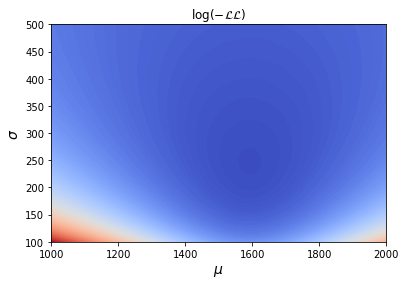

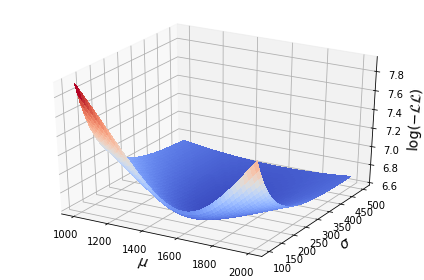

In [16]:
import numpy as np
import scipy
from matplotlib.colors import LogNorm
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
  
#code for creating a contourplot
#values for meshgrid and levels were tweaked for educational purposes
vnll=np.vectorize(nll)
xv, yv= np.meshgrid(np.linspace(1000, 2000, 200),np.linspace(100, 500, 200))
zv=np.log(vnll(xv,yv)) #because of the huge difference in LL values, we will plot the log of the value
contour = plt.contourf(xv,yv,zv,levels=200,cmap=cm.coolwarm);        
contour.ax.set(xlabel="$\mu$",ylabel="$\sigma$")
contour.ax.xaxis.label.set_fontsize(14)
contour.ax.yaxis.label.set_fontsize(14)
plt.title('$\log(-\mathcal{LL})$')

#code for creating 3D surface plot
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot_surface(xv, yv, zv, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('$\mu$',fontsize=14)
ax.set_ylabel('$\sigma$',fontsize=14)
ax.set_zlabel('$\log(-\mathcal{LL})$',fontsize=14)
plt.tight_layout()

<font color='red'>Visual inspection is obviously quite inaccurate.
* Use the code below to numerically determine the minimum of the negative loglikelihood.
* Calculate the mean and standard deviation of your dataframe with built-in methods. For the standard deviation, you should set <tt>ddof=0</tt>. These results should compare with numerically calculated minimum. 
</font>

In [17]:
from scipy.optimize import minimize
import scipy.stats
#the minimize function requires a signature with a single argument
def nll_par(par):    
    m = par[0]   
    s = par[1]
    return nll(m,s)

initParams = [1, 1]
results = minimize(nll_par, x0=np.array(initParams), method='Nelder-Mead')
[mu_est, sigma_est] = results.x
print('Estimated parameter values [\u03BC,\u03C3] = ',results.x)


#direct calculation of mean and standard deviation
print(diff_oven.mean())
print(diff_oven.std(ddof=0))

Estimated parameter values [μ,σ] =  [1592.40421584  245.99471441]
1592.4056
246.02068


One can indeed prove that solving the set of partial derivatives of the $\mathcal{LL}$ of the Gaussian family results in the familiar estimation of mean and sigma, see [this blogpost](http://jrmeyer.github.io/machinelearning/2017/08/18/mle.html). There is no need to use the loglikelihood method when working with a univariate Gaussian distribution. However, the MLE method is generic and is the only one we can use when using more complex distributions, such as Gaussian mixtures and multivariate distributions. 

Let's now have a look to a situation when there are two clusters in the data. For this, we will estimate the parameters of a mixture of Gaussians.


# One dimension, multiple Gaussians

## Distribution of power differences measured on a light circuit

In most households, the light circuits are separated from socket circuits. Let's first explore this data by plotting the power distribution over time of the meter that corresponds with the first light circuit (instance 9). 

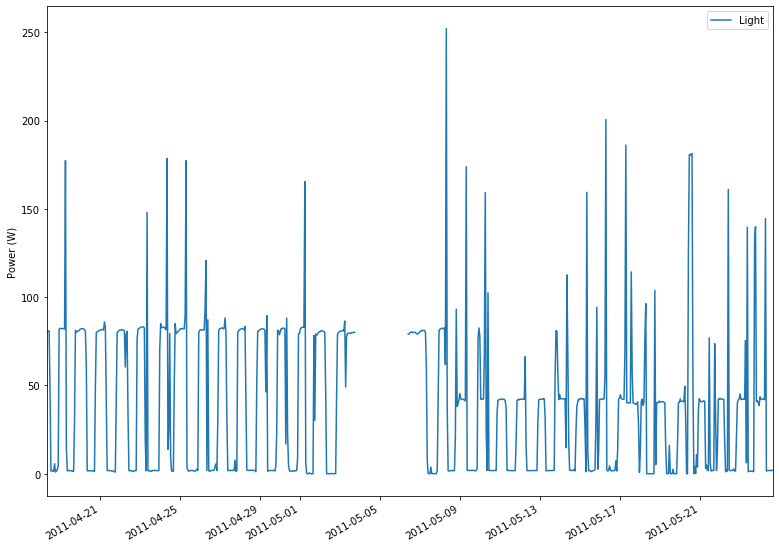

In [18]:
from matplotlib import rcParams
from datetime import datetime


rcParams['figure.figsize']=(13,10);
elec[9].plot();

#from nilmtk import timeframe
#tf=timeframe.TimeFrame(datetime(2011,5,16),datetime(2011,5,25))
#elec[9].plot(timeframe=tf)


This plot should it make clear for you that there are multiple light devices connected to this circuit, each with their own distribution of power differences.

<font color='red'>Task:
* Create a dataframe that contains the absolute values of the power difference between subsequent samples.
* Plot a histogram of the power differences. The histogram is again dominated by a large number of noise. Use the approach with the ECDF function to determine an appropriate threshold value and filter your data. Choose an appropriate range for the Y-axis, and cut-off at the first elbow.
* In the plot above, you also observe very high peaks. These peaks are due to electrical effects that occur when opening a closed circuit, or vice versa. Filter out these high values as well (inspect the elbows on your ECDF).
* Plot a histogram of your filtered data. 
</font>

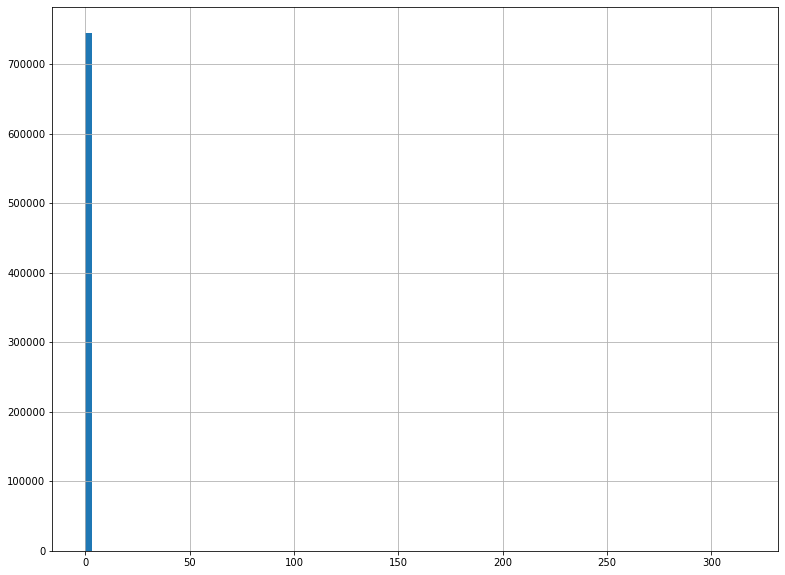

In [19]:
light_data=next(elec[9].load());
diff_light=abs(light_data.power.active.diff());
diff_light.hist(bins=100);

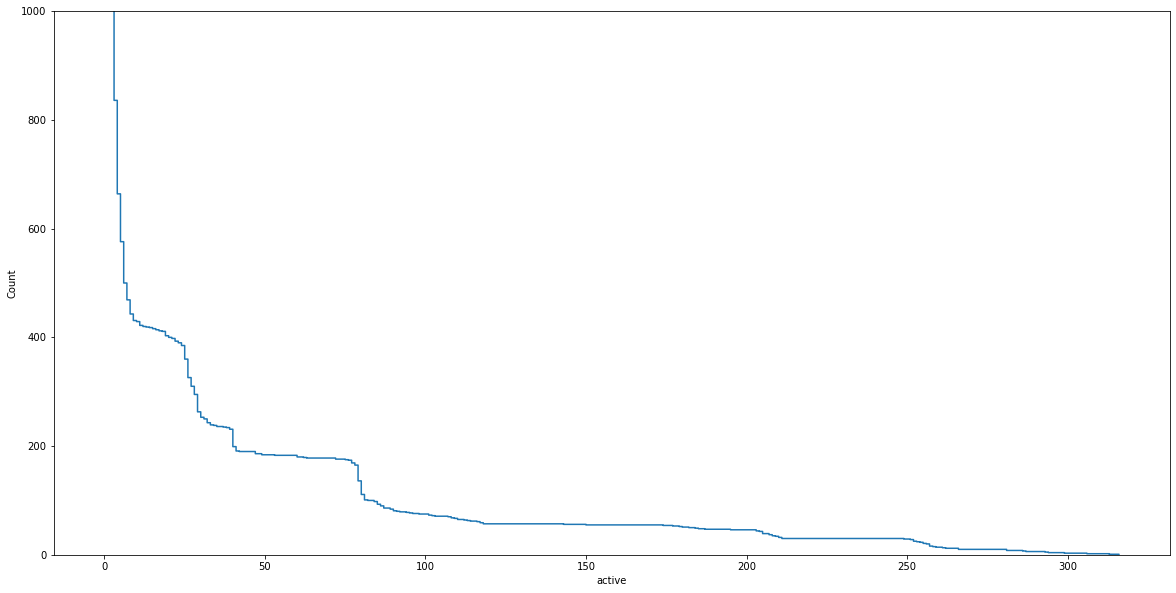

In [20]:
import seaborn as sns
plt.figure(figsize=(20,10));
sns.ecdfplot(data=diff_light, stat="count",complementary=True)
plt.ylim(0,1000);


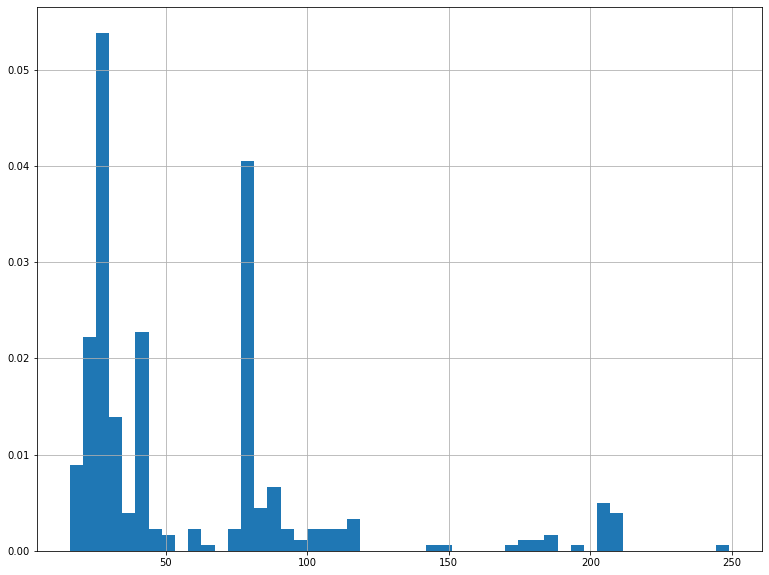

In [21]:
diff_light=diff_light[(diff_light>15) & (diff_light<250)]
diff_light.hist(bins=50,density=True);
#diff_light[(diff_light>15) & (diff_light<250)].plot.density()

The histogram has multiple peaks. We call such local maxima the **modes** of the distribution. The Gaussian distribution  has only a single mode, so it is unlikely that a density estimation with this family will provide good results. We need a **multimodal** distribution.

## Gaussian Mixture
The data collected on this meter is actually the result of multiple lights. Each light (likely) corresponds to one mode in the distribution of the power differences on this circuit. Some lights are more frequently switched on or off than others (think about your own house). The heights of the modes are determined by how often a particular light is switched on or off. 

A commonly used multimodal distribution is a mixture of Gaussians. A Gaussian mixture is a weighted linear combination of unimodal Gaussian distributions:
$$
\begin{align}
p(x) = \sum_{i=1}^k \phi_i \mathcal{N}(x;\mu_i,\sigma_i)
\end{align}
$$
To have a valid probability distribution, the mixture proportions $\phi_i$ should sum to 1: $\sum_{i=1}^k \phi_i = 1$.
<br><br>
<font color='red'>Plot some examples of the Gaussian distribution below. What effects result from changing $\mu$, $\sigma$ and $\phi$?</font>

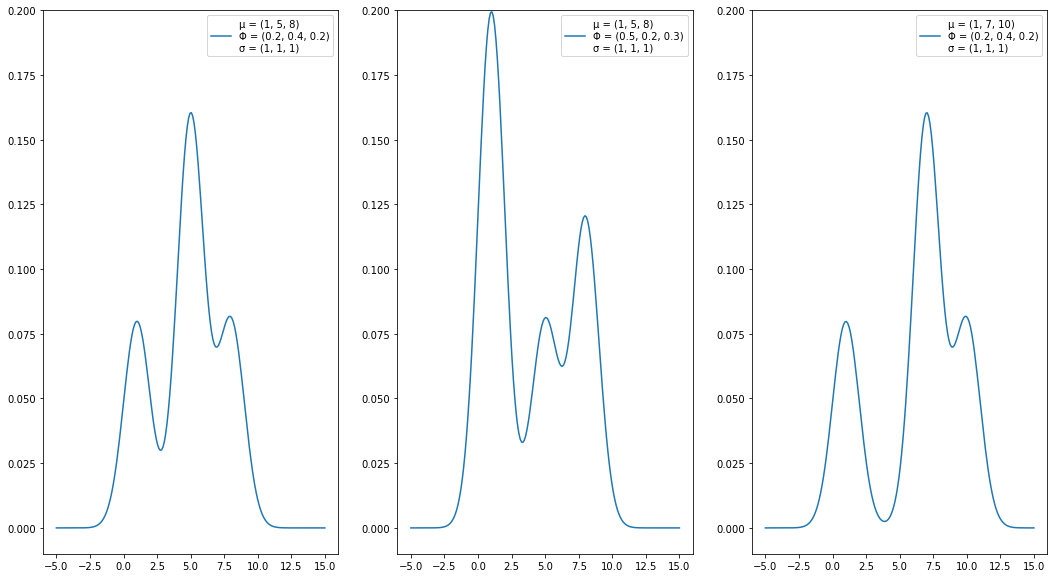

In [22]:
from scipy.stats import expon,norm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

values=[[(1,5,8),(1,1,1),(0.2,0.4,0.2)],
        [(1,5,8),(1,1,1),(0.5,0.2,0.3)],
        [(1,7,10),(1,1,1),(0.2,0.4,0.2)]
       ]

xv=np.linspace(-5,15,num=200)
for index,(m,s,w) in enumerate(values):
    sns.lineplot(x=xv,y=w[0]*norm.pdf(xv,loc=m[0],scale=s[0])+w[1]*norm.pdf(xv,loc=m[1],scale=s[2])+w[2]*norm.pdf(xv,loc=m[2],scale=s[2]),ax=axes[index])
    axes[index].set_ylim(-0.01,0.2)
    axes[index].legend(['\u03BC = ('+str(m[0])+', '+str(m[1])+', '+str(m[2])+')'+'\u000a\u03a6 = ('+str(w[0])+', '+str(w[1])+', '+str(w[1])+')'])   


## Method: Expectation Maximization

When applying our loglikelihood estimation on the Gaussian Mixture distribution family, we need to estimate the means, variances and mixture proportions of the Gaussians.

$$
\begin{align}
p_{model}(x;\mathbf{\theta}) &= p_{model}(x;[\phi_1, \mu_1, \sigma_1, ... , \phi_k, \mu_k, \sigma_k]) \\
                     &= \sum_{j=1}^k \phi_j \mathcal{N}(\mu_j,\sigma_j) \\
\mathcal{LL}(\phi_1, \mu_1, \sigma_1, ... , \phi_k, \mu_k, \sigma_k) &= \sum_{i=1}^N \log\left(\sum_{j=1}^k \phi_j \mathcal{N}(x^{(i)};\mu_j,\sigma_j) \right)
\end{align}
$$

This function is difficult to optimize, because the sum of components appears *inside* the log. The parameters are coupled: there are no separate terms containing only $\phi_i$ and $\mu_i, \sigma_i$.

Fortunately, there exists an iterative algorithm to estimate the parameters: the **expectation-maximization step**. It assumes that the data is generated from $k$ hidden (also called **latent**) sources. You can think of this like tossing up a $k$-side coin, and the outcome determines from which source the data came. The data of each source is normally distributed with parameters $\mu_i$ and $\sigma_i$. In our example, you could think of the different lights on the circuit
with (initially equal) probabilities $\pi_i$ that a datasample $x$ is generated by switching light $i$. 

Intuitively, the problem comes down to assigning samples to one of the $k$ Gaussians with a particular probability, and then finding the optimal mean and standard deviation that maximizes the likelihood of that cluster. 

Finding these parameters is done with the **expectation-maximization** algorithm. The algorithm iterates between two steps, the expectation step and the maximization step. It alternates between finding the probabilities for each point to be generated by each mixture and fitting the mixture to these assigned points. 

<font color='red'>Task:
* Fit a Gaussian Mixture model on the data of the light circuit with the <tt>GaussianMixture</tt> class of the <tt>sklearn.mixture</tt> package. This method executes the EM algorithm and expects the number of components as argument. Inspect your histogram and choose a sensible value. 
* The function below allows you to plot the density function of your Gaussian Mixture. Compare it with your histogram. does it correspond?
</font>

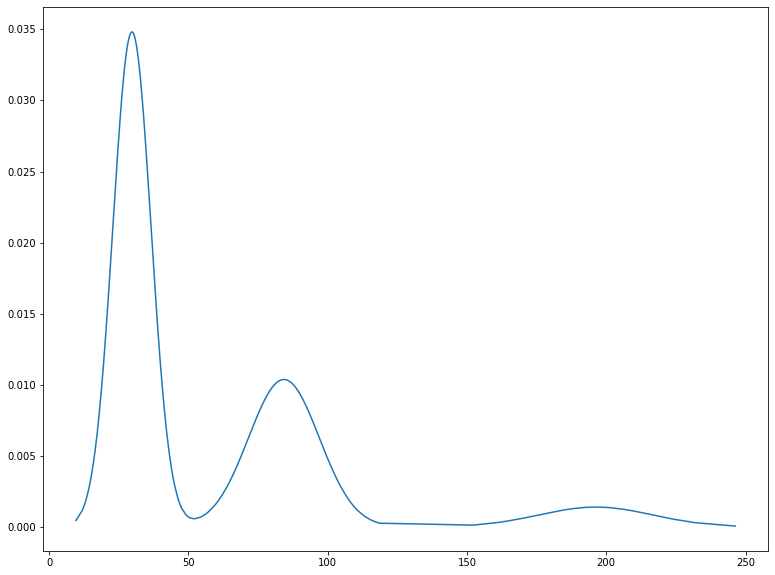

In [23]:
from sklearn.mixture import GaussianMixture
gmm_light= GaussianMixture(n_components=3).fit(diff_light.dropna().values.reshape(-1,1))

def plot_estimatedGMM(gmm):
    #cov_reshaped=np.reshape(covariances_,(-1,1))
    [samples,clusters] = gmm.sample(1000)
    min_samples=samples.min()
    max_samples=samples.max()    
    sns.lineplot(x=samples.reshape(-1),y=(np.exp(gmm.score_samples(samples))).reshape(-1))    

plot_estimatedGMM(gmm_light)


Suppose you observe two new jumps in the voltage, one of 30V and one of 60 V. 

<font color='red'>To what cluster number (~light) should you attribute this new sample? Use the <tt>predict</tt> and <tt>predict_proba</tt> methods of your trained <tt>GaussianMixture</tt>. Can you interpret the output of both methods?</font>

In [24]:
newsample=np.array([30, 60]).reshape(-1,1);
print(gmm_light.predict(newsample)) #prints the number of the cluster with max probability density
print(gmm_light.predict_proba(newsample)) #prints the probability density according to each Gaussian

[0 2]
[[9.99968463e-01 2.11619858e-16 3.15374106e-05]
 [1.18501053e-03 2.16090864e-10 9.98814989e-01]]


# Multiple dimensions, multiple Gaussians

We are now ready to tackle the most generic problem in $d$-dimensional space.

## Multivariate Gaussian Mixture Models

The extension of a Gaussian Mixture with $k$ components to multi-dimensional feature vectors is straightforward. Here again, the logarithm and exponential in the loglikelihood will nicely cancel eachother out.
$$
\begin{align}
p_{model}(\mathbf{x};\mathbf{\theta}) &= \sum_{j=1}^k \phi_j \mathcal{N}(\mathbf{x};\mathbf{\mu_j},\mathbf{\Sigma_j)} \\
                                      &= \sum_{j=1}^k \phi_j \frac{1}{\sqrt{\left(2 \pi \right)^{d} |\Sigma|}}\rm{exp}\left(-\frac{1}{2}\left(\mathbf{x} - \mathbf{\mu_j}\right)^T \mathbf{\Sigma_j^{-1}}\left(\mathbf{x}-\mathbf{\mu_j}\right)\right) \\
\mathcal{LL}\left(\phi_1, ... \phi_k, \mathbf{\mu_1}, ... , \mathbf{\mu_k}, \mathbf{\Sigma_1}, ... ,\mathbf{\Sigma_k}\right) &= \sum_{i=1}^N \log\left(\sum_{j=1}^k \phi_j \mathcal{N}(\mathbf{x^{(i)}};\mathbf{\mu_j},\mathbf{\Sigma_j)}  \right)
\end{align}
$$


## Reducing the number of parameters

Observe the large number of parameters that have to be estimated by the MLE method. Each vector $\mathbf{\mu_j}$ contains $d$ parameters, and each covariance matrix $\mathbf{\Sigma}_j$ contains $d^2$ parameters. When there are many dimensions, many clusters or few instances, the Expectation Maximization Algorithm can struggle to converge to the optimal solution. 

You might need to reduce the difficulty of the task by limiting the number of parameters that the algorithm has to learn. This can be achieved in two ways (that you can combine):
* by reducing the dimensionality $d$, e.g. using PCA.
* by imposing constraints on the elements of the covariance matrices. Obviously, this will affect your clustering result.

<font color='red'>Task: 
* fit a Gaussian Mixture with 3 components on the sample data below and inspect the density plot. 
* Experiment with the four different values of the <tt>covariance_type</tt> hyperparameter of the <tt>GaussianMixture</tt>: <tt>full</tt>, <tt>spherical</tt>, <tt>diag</tt>, <tt>tied</tt>. 
* What is the effect of this hyperparameter on the size, orientation and shape of the Gaussians?
* How much does each hyperparameter reduce the number of parameters to be estimated?
</font>

In [25]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=5, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #plt.contour(xx, yy, Z,
    #            linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


In [26]:
#full means that each cluster can take on any shape, size and orientation
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
#tied enforces that all clusters have the same ellipsoidal shape, size and orientation. All clusters share the same covariance matrix.
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42) 
#spherical ensures that all clusters are spherical, but they can have different diameters. This means that each cluster has a diagonal covariance matrix with all elements equal (but different between clusters)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
#diagonal ensures that all clusters have a diagonal covariance matrix, with possibly different values for the diagonal elements of a single matrix. Each cluster has its own matrix.  This means that each cluster will have an ellipse aligned to the X or Y axis.
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

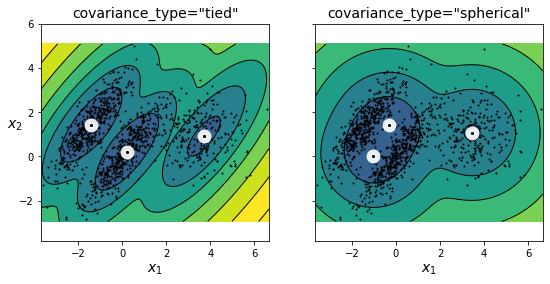

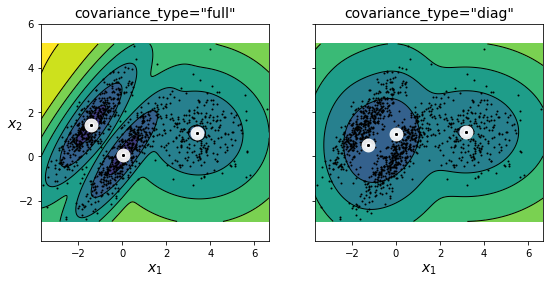

In [27]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))
    
    plt.subplot(121)
    plt.axis("equal")
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plt.axis("equal")
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

    
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

compare_gaussian_mixtures(gm_full, gm_diag, X)
#plt.tight_layout()
plt.show()

## Determining the number of components

With k-means, we could use the inertia or silhouette score to select the appropriate number of clusters. But with Gaussian Mixtures, it is not possible to use these metrics because they are not reliable when the clusters are not spherical or have different sizes.

Instead, you can try to find the model that minimizes a *theoretical information criterion*, such as the *Bayesian information criterion* (BIC) or the *Akaike information criterion* (AIC). These values are calculated from the number of samples in your dataset, the number of parameters learned by the model and the maximized value of the likelihood. 

Both BIC and AIC penalize models that have more parameters to learn (e.g. more components) and reward models that fit the data well. They often end up selecting the same model. When they differ, the model selected by the BIC tends to be simpler (fewer parameters) than the one selected by AIC, but tends to not fit the data quite well as well. This is especially true for larger datasets. 

Both values for a trained GMM can be retrieved via the <tt>GaussianMixture.bic()</tt> and <tt>GaussianMixture.aic()</tt> methods.

## Clustering the IRIS dataset

Let's apply everything you have learned so far.

<font color='red'>Task:
* Fit a Gaussian Mixture with varying number of components to the original data. You do not need to apply dimensionality reduction (if you would use PCA, you would have to normalize your data first!). Set the covariance type to <tt>full</tt>. Plot the BIC and AIC as a function of the number of components. What is the best no. you can get?
* Repeat the previous question, but now for the three other types of covariance matrices. What combination of no. of components and covariance matrix type gives you the best result (lowest BIC and AIC)?
* Optional: compare your clustering results with the ground truth labels. You can do this with the <tt>adjusted_rand_score</tt> metric from <tt>sklearn.metrics.cluster</tt>. What percentage of the samples is in the correct cluster?
</font>

In [28]:
#loading and preprocessing data
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
iris = load_iris()
iris_data = pd.DataFrame(np.concatenate((iris.data, np.array([iris.target]).T), axis=1), columns=iris.feature_names + ['target'])

#split data in features and in labels
iris_features = iris_data.iloc[:,0:4]
iris_labels = iris_data.iloc[:,-1]

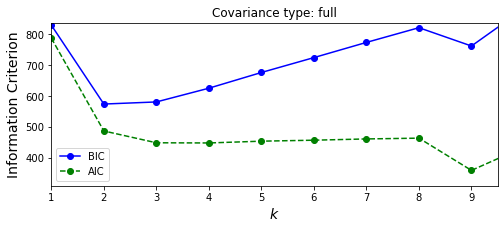

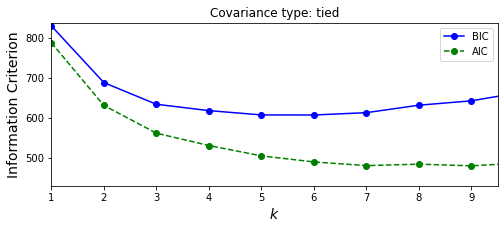

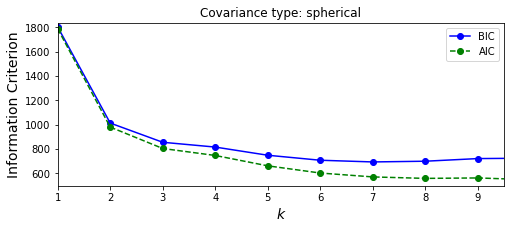

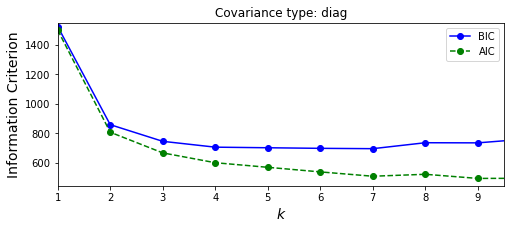

In [29]:
#HYPERPARAMETER SEARCH FOR FITTING GAUSSIAN MIXTURE ON ORIGINAL 4-D DATA

from sklearn.mixture import GaussianMixture

min_bic = np.infty

for cov_type in ("full", "tied", "spherical", "diag"):
    gms_per_k = [GaussianMixture(n_components=k, covariance_type= cov_type).fit(iris_features)
             for k in range(1, 11)]
    bics = [model.bic(iris_features) for model in gms_per_k]
    aics = [model.aic(iris_features) for model in gms_per_k]
    
    plt.figure(figsize=(8, 3))
    plt.plot(range(1, 11), bics, "bo-", label="BIC")
    plt.plot(range(1, 11), aics, "go--", label="AIC")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Information Criterion", fontsize=14)
    plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
    plt.title("Covariance type: "+ cov_type)
    plt.legend()   
    plt.show()

# Other applications of generative modelling

Until now, we studied maximum likelihood estimation in the context of clustering. With MLE, we try to select from a family of distributions the member that best approximates the true underlying - but unknown - data distribution $p_{data}$ that actually **generated** the data.
<p float="left">
  <img src="./images/generativemodelling.png" width="200" />
  <img src="./images/learning_2.png" width="200" />   
</p>

This process of **generative modelling** is useful in many other applications, of which we will study sampling and anomaly detection.

### The Olivetti dataset
Load the Olivetti dataset, which contains 400 grayscale 64 $\times$ 64 pixel images of faces. 40 different perons were photographed (10 times each).
Each image is described with a feature vector of dimension 64 $\times$ 64 $=$ 4096. Each feature is the grey scale value of a particular pixel. Pixels are iterated over from left to right, row by row. Note that the grey scales values have already been normalized.

In [30]:
from sklearn import datasets

faces=datasets.fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Show some samples:

[36, 20, 24, 0, 17]


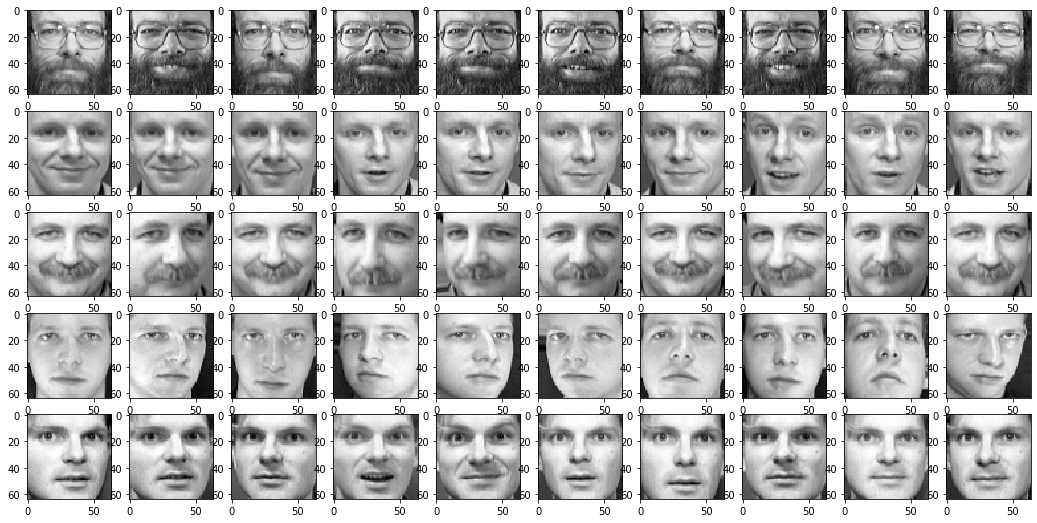

In [31]:
import random
import matplotlib.pyplot as plt
import numpy as np

def show_olivetti_samples(images):
    total_persons=40
    no_persons=5
    no_imagesperperson=10
    #Creating no_persons X no_imagesperperson subplots in  18x9 figure size
    
    fig, axarr=plt.subplots(nrows=no_persons, ncols=no_imagesperperson, figsize=(18, 9))
    #For easy iteration flattened subplots matrix to array
    axarr=axarr.flatten()
    
    #sample 5 user ids, and show all pictures of that person    
    selected=random.sample(range(0,total_persons), no_persons)
    print(selected)
    #iterating over selected users
    for i in range(0,no_persons):
        for j in range(0,no_imagesperperson):
            axarr[i*no_imagesperperson+j].imshow(images[selected[i]*no_imagesperperson+j].reshape(64,64), cmap='gray')    
    
show_olivetti_samples(faces.data)

### Fitting a GMM to a distribution of greyscale images

We model these images as being sampled according to an underlying density function $p_{data}(x_1,...,x_{4096})$. Each feature can take a value between 0 and 1. Intuitively, you can indeed imagine that only a very small number of all possible 4096-tuples will result in the picture of a face (most combinations would give you noise). Each image in our dataset is a "good" combination of pixel values. Changing randomly one pixel of an image will still result in a very similar image of a face. But if you start moving further away in feature space from the original point by randomly changing pixel values, you will ultimately end up with noise. So you can imagine that there is a region in the 4096 feature space that corresponds with pictures of this person. Similarly, there will be another region (cluster) of points corresponding to the pictures of another person. The true density distribution $p_{data}$ will have a high value in these regions of the feature space, and very low values in regions corresponding with noisy images.

Our aim is to approximate this density function with a Gaussian Mixture Model $p_{model}$ that we learn from data.

Fitting a GMM on data of such a high dimension is infeasible.<br><br>

<font color='red'>
Task: reduce the dimensionality of your data with PCA. Select an appropriate number of components to explain 99% of the variance. (hint: have a look at possible arguments for the <tt>PCA</tt> estimator.)   
</font>    

No of components selected:  260


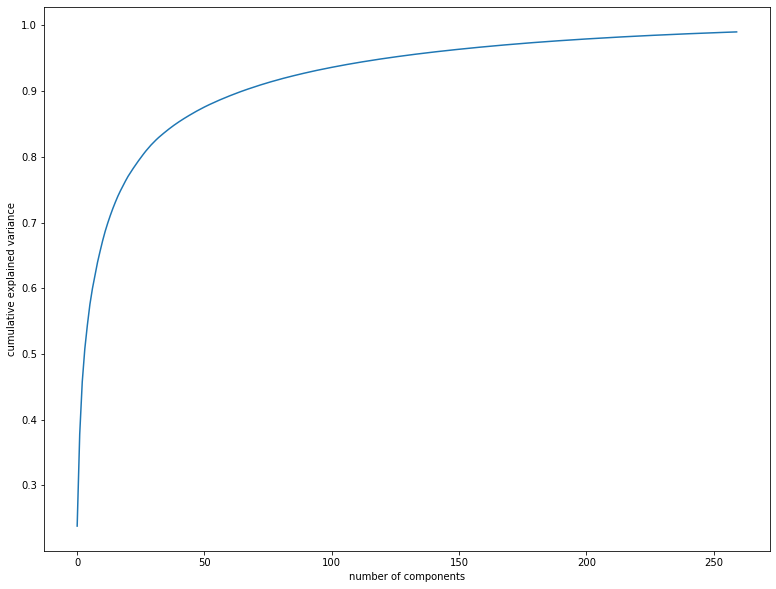

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
data_reduced = pca.fit_transform(faces.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

print('No of components selected: ',pca.components_.shape[0])

<font color='red'>Task:
* Fit a GMM with the selected number of components on your data with reduced dimensionality.
* Use the BIC and AIC to determine an optimal number of clusters. You can use a <tt>full</tt> covariance matrix. Hint: avoid doing a search over a large number of components. The number is much lower than 40!
</font>

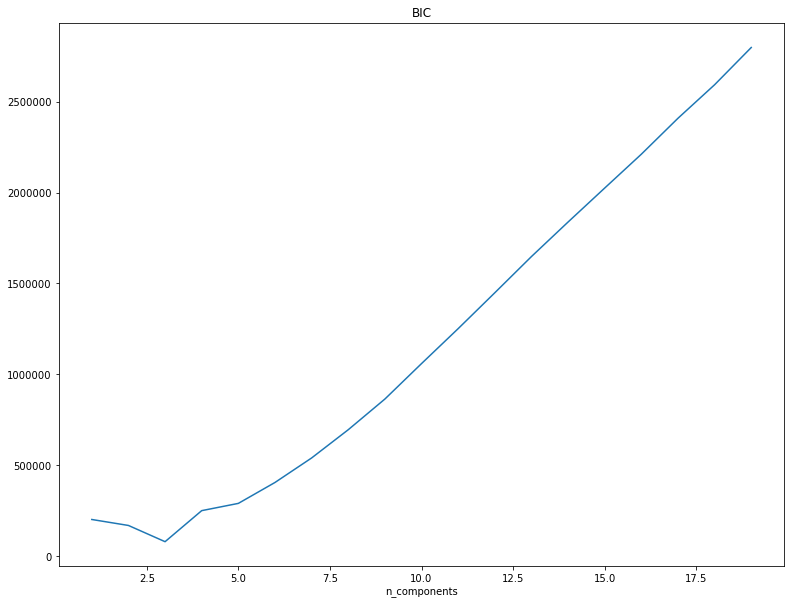

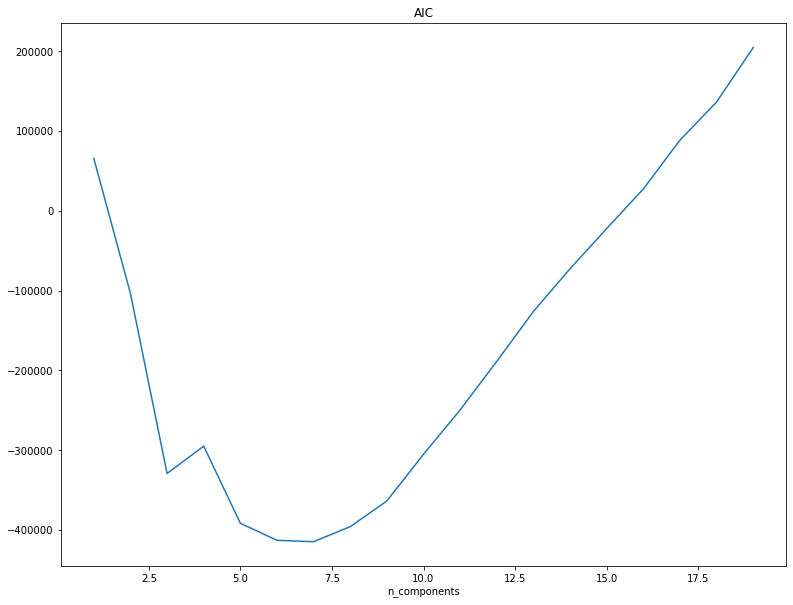

In [33]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 20)
models = [GaussianMixture(n, random_state=0).fit(data_reduced)
          for n in n_components]
plt.plot(n_components, [m.bic(data_reduced) for m in models], label='BIC')
plt.xlabel('n_components');
plt.title('BIC')
plt.show()
plt.plot(n_components, [m.aic(data_reduced) for m in models], label='AIC')
plt.title('AIC')
plt.xlabel('n_components');
plt.show()

In [34]:
image_generator=GaussianMixture(n_components=7)
image_generator.fit(data_reduced)

GaussianMixture(n_components=7)

### Sampling new faces

When you take $N$ samples from a given probability distribution, the majority of the samples would be in feature regions having a high probability density. If we sample from our learned Gaussian Mixture Model, we should thus obtain with a high probability images that resemble faces in our dataset! 
<br><br>

<font color='red'>Task: 
* Use the <tt>sample()</tt> method to sample 10 feature vectors from your fitted <tt>GaussianMixture</tt>.
* These samples are taken from the reduced dimensionality space and do not reflect yet actual images. We can project them back to the original $64 \times 64$ space by the <tt>inverse_transform()</tt> method of PCA. Show the generated images. Does any of your generated images resemble a person from the dataset? 
</font>

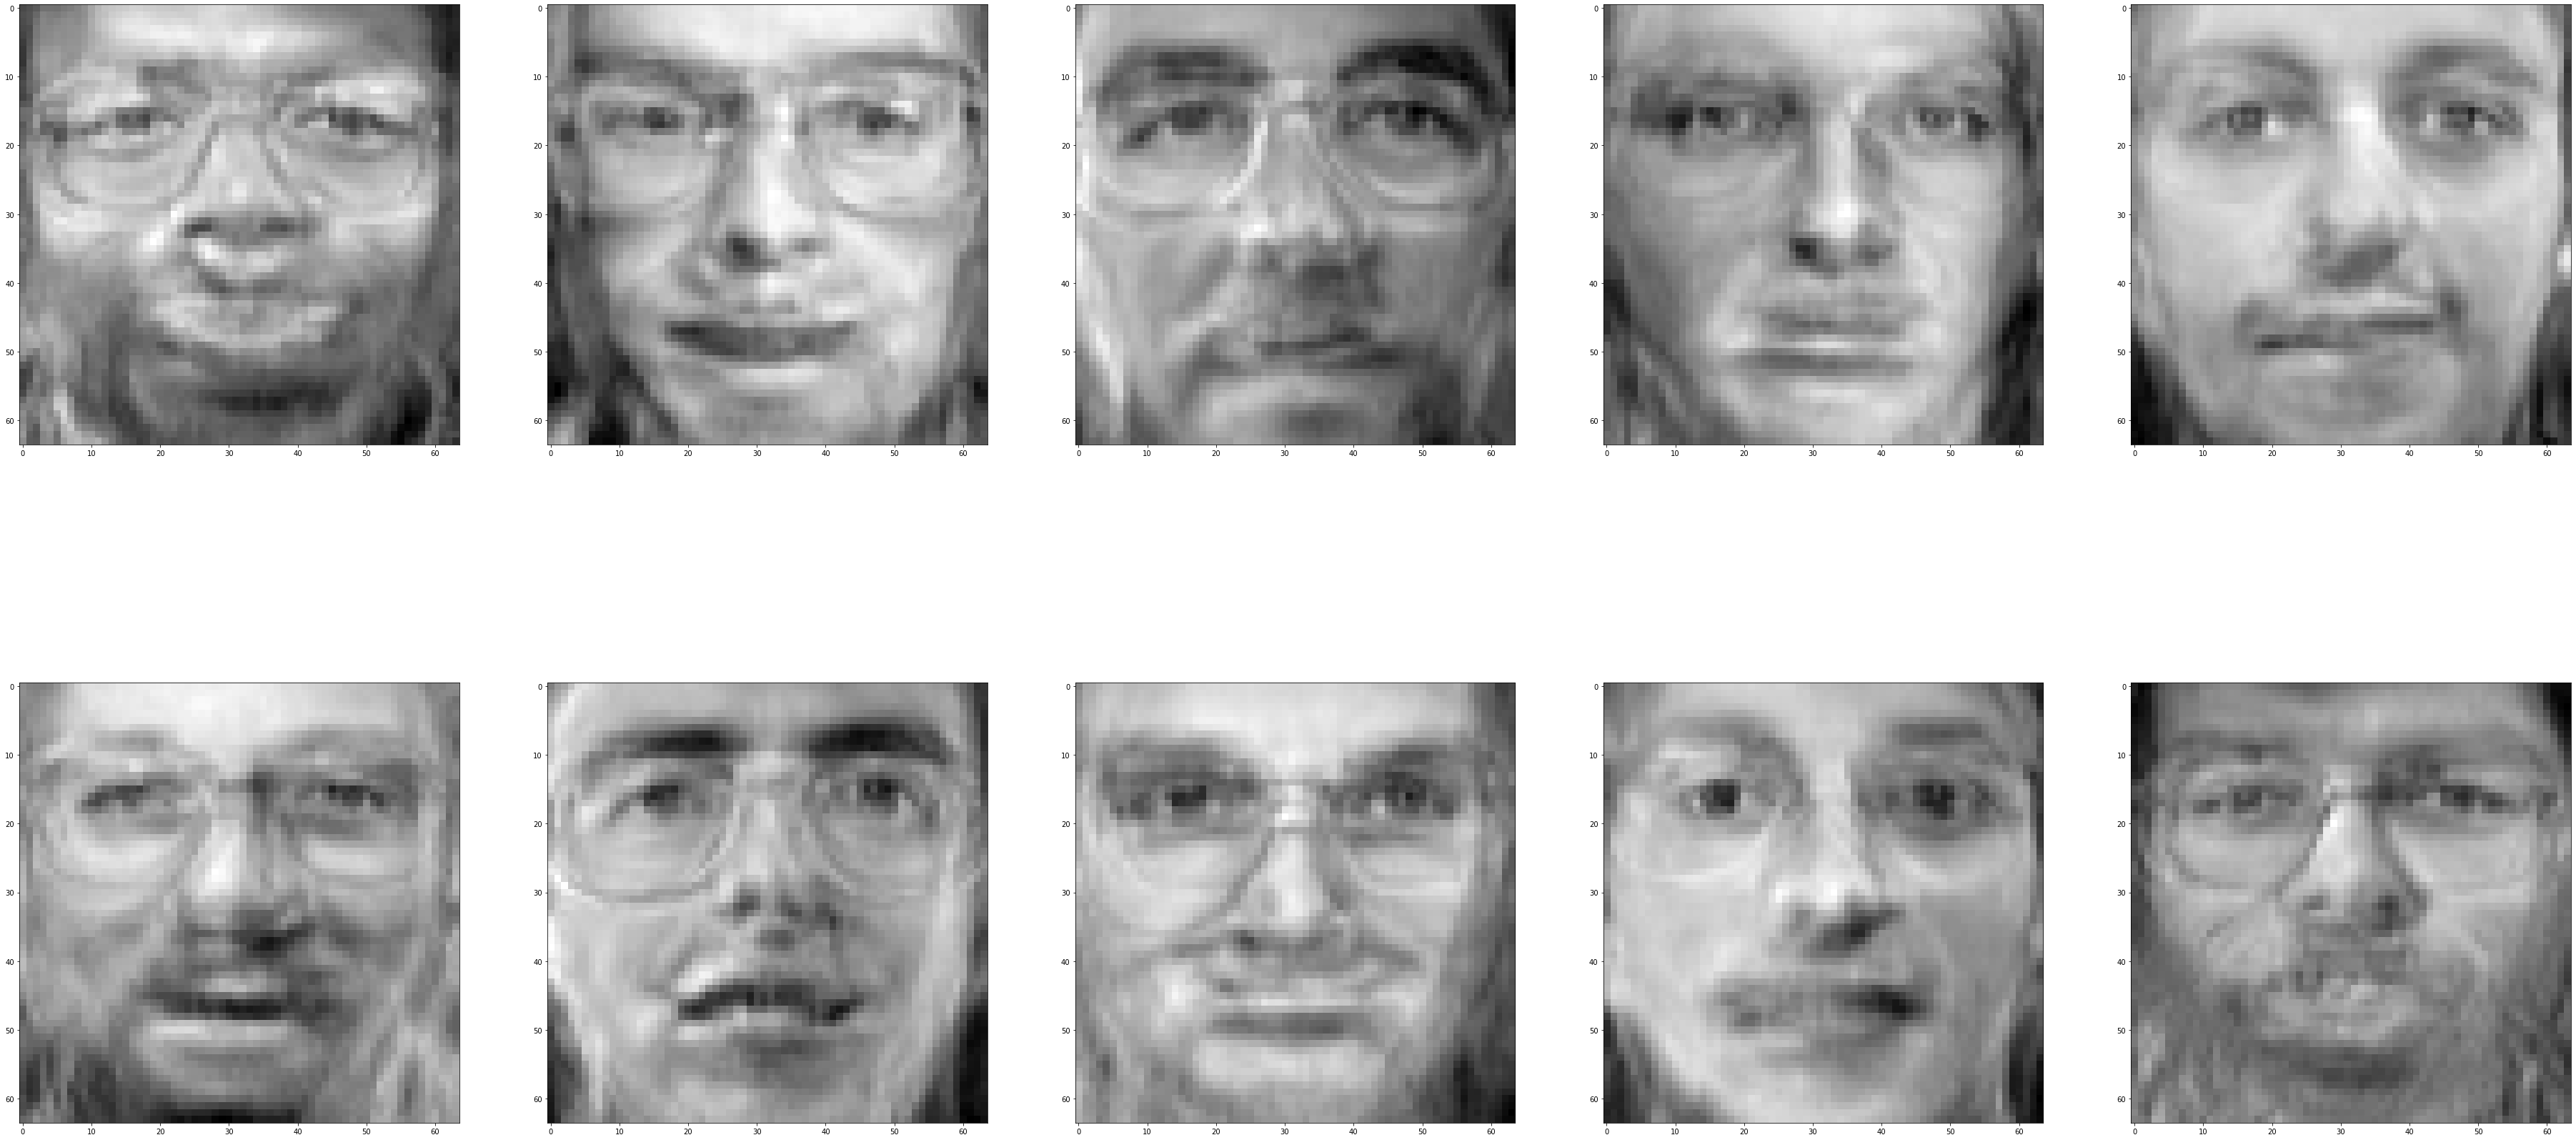

In [35]:
fig, axs = plt.subplots(2,5, figsize=(64, 32))
axs = axs.ravel()
   
for i in range(0,10):
    sample,mode_id=image_generator.sample()
    axs[i].imshow(pca.inverse_transform(sample).reshape(64,64),cmap='gray')    

You will notice that the generated images are blurry. This is due to the Gaussian distribution, who doesn't allow to model very sharp (peaked) distributions. Another reason is that some information was lost due to the dimensionality reduction. 

### Anomaly Detection

Generative models can also be used for anomaly detection. New samples, e.g. a new measurement or a new photo, that have a very low probability according to the learned GMM will likely be an outlier to the training dataset.

<font color='red'>
Run the code below to visualize some $64 \times 64$ greyscale images that are valid but that are outliers because they do not contain faces.</font>

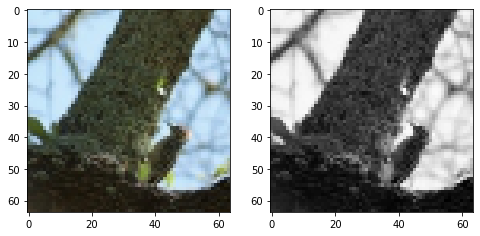

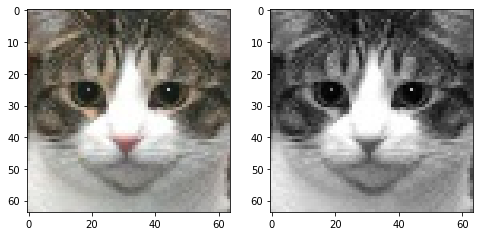

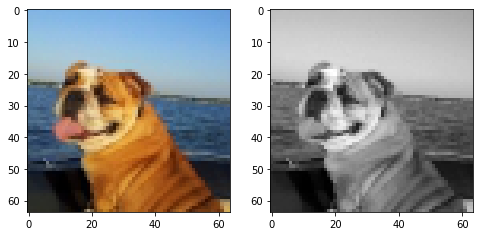

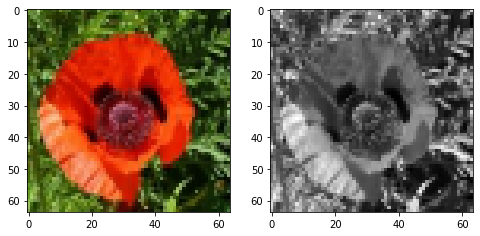

In [36]:
from skimage import color
from skimage import io

images=['./images/bird.jpg','./images/cat.jpg','./images/dog.jpg','./images/flower.jpg']

for image in images:
    img = io.imread(image)    
    imgGray = color.rgb2gray(img)         
    fig, axs = plt.subplots(1,2, figsize=(8, 8))
    axs = axs.ravel()
    axs[0].imshow(img)    
    axs[1].imshow(imgGray,cmap='gray')    
    plt.show()

<font color='red'>Task:
* Compare the score of the above images with the score of a few samples in the training set, using the <tt>score_samples()</tt> method of <tt>GaussianMixture</tt>. This score is not a probability, and also not a probability density, but the logarithm of the probability density. Remember that you trained your GMM on the PCA-reduced data, so don't forget to transform these images!
</font>

In [37]:
for image in images:
    img = io.imread(image)
    imgGray = color.rgb2gray(img)         
    print(image,image_generator.score_samples(pca.transform(imgGray.flatten().reshape(1,-1))))

image_generator.score_samples(data_reduced[:10])

./images/bird.jpg [-37552596.70787764]
./images/cat.jpg [-24387701.03092637]
./images/dog.jpg [-14811446.74097579]
./images/flower.jpg [-19315397.53499477]


array([1166.84643298, 1037.77128731, 1166.84636326, 1199.98206117,
       1166.8463323 , 1199.98198548, 1166.84641358, 1166.84640885,
       1166.84635553,  853.10392065])

To conclude this part, let's have a look at the score of two face crops that were not in the dataset. The pictures of Matteo Simoni and Angelina Jolie have both been scaled to 64x64. The crop is similar to the dataset. The scores should be lower than the scores for items in the trainingset, but higher than the scores for an image of a flower, dog or cat...

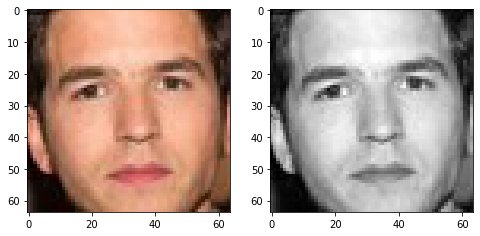

./images/matteo.jpg [-12670170.46595037]


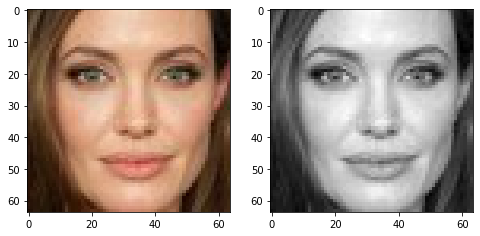

./images/angelina.jpg [-8724456.26115967]


In [38]:
from skimage import color
from skimage import io

images=['./images/matteo.jpg','./images/angelina.jpg']

for image in images:
    img = io.imread(image)    
    imgGray = color.rgb2gray(img)         
    fig, axs = plt.subplots(1,2, figsize=(8, 8))
    axs = axs.ravel()
    axs[0].imshow(img)    
    axs[1].imshow(imgGray,cmap='gray')    
    plt.show()
    print(image,image_generator.score_samples(pca.transform(imgGray.flatten().reshape(1,-1))))

# Conclusion
Gaussian Mixtures and the method of density modelling are very powerful. Oftentimes, you have to reduce the computational complexity by dimensionality reduction and by imposing constraints on the covariance matrices.

Another caveat is that this problem performs not so good when the distribution of your feature values is very skewed. In this case, you should first apply an additional transformation to your features to reduce the skew. A very nice example can be found on this [blog](https://www.kaggle.com/allunia/hidden-treasures-in-our-groceries).
            

# Bibliography
The following sources were consulted to set up this notebook:
 * http://jrmeyer.github.io/machinelearning/2017/08/18/mle.html
 * https://mas-dse.github.io/DSE210/Additional%20Materials/gmm.pdf
 * https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/
 * https://www.kaggle.com/bburns/iris-exploration-pca-k-means-and-gmm-clustering
 * https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
 * https://www.kaggle.com/bburns/iris-exploration-pca-k-means-and-gmm-clustering/notebook
 * https://deepgenerativemodels.github.io
 * Alpaydin E, Introduction to Machine Learning (4th edition).
 